# Deeplabcut analysis

## Step 1: Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import zipfile
import umap
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Step 2: Load the Data

In [3]:
path_to_extracted_folder = 'E:/deeplabcut/'
data_files = os.listdir(path_to_extracted_folder)
saline_files = [file for file in data_files if any(mouse in file for mouse in ['322', '328', '330', '332'])]
pfa_files = [file for file in data_files if any(mouse in file for mouse in ['326', '327', '334', '335', '336'])]

saline_dataframes = [pd.read_csv('E:/deeplabcut/' + file, header=[1,2]) for file in saline_files]
pfa_dataframes = [pd.read_csv('E:/deeplabcut/' + file, header=[1,2]) for file in pfa_files]

In [4]:
frame_info_df_manual = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_led_frames.csv')

### data cropping to keep 54000 frames in each session

In [5]:
def crop_dataframe(df, file_name):
    # Extract the mouse name from the filename, stripping extensions or additional characters if needed
    mouse_name = file_name.split('DLC')[0].rstrip('_')
    start_frame = frame_info_df_manual[frame_info_df_manual['Filename'] == mouse_name]['Start'].values[0]
    return df.iloc[start_frame : start_frame + 54000]

saline_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(saline_dataframes, saline_files)]
pfa_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(pfa_dataframes, pfa_files)]


## Step 3: Data Cleaning

In [20]:
df_box

,mouse_NO.,top_left_x,top_left_y,top_right_x,top_right_y,bottom_right_x,bottom_right_y,bottom_left_x,bottom_left_y,box_center_x,box_center_y
0,322,430,172,962,180,954,442,422,434,692.0,307.0
1,322_sal,433,174,967,180,964,441,430,435,698.5,307.5
2,326,429,175,961,177,958,439,426,437,693.5,307.0
3,326_pfa,426,178,959,184,953,445,420,439,689.5,311.5
4,327,432,173,966,181,958,441,424,433,695.0,307.0
5,327_pfa,425,172,959,181,954,443,420,434,689.5,307.5
6,328,427,169,962,182,955,444,420,431,691.0,306.5
7,328_sal,427,172,961,179,954,441,420,434,690.5,306.5
8,330,429,174,962,180,959,442,426,436,694.0,308.0
9,330_sal,427,177,961,184,956,446,422,439,691.5,311.5


In [14]:
def clean_data_modified(df):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Replace missing values or NaN with interpolation on the copy
    df_copy.interpolate(method='linear', inplace=True, limit_direction='both')
    
    return df_copy

# Applying the modified function to the cropped dataframes
saline_dataframes_cleaned = [clean_data_modified(df) for df in saline_dataframes_cropped]
pfa_dataframes_cleaned = [clean_data_modified(df) for df in pfa_dataframes_cropped]


In [15]:
# List of specified body parts
body_parts = ['head', 'leftEar', 'rightEar', 'centerofMass', 'leftHip', 'rightHip', 'tailRoot']

def compute_center_coordinates(df):
    # Extracting x and y coordinates for the specified body parts
    x_coords = df.loc[:, pd.IndexSlice[body_parts, 'x']]
    y_coords = df.loc[:, pd.IndexSlice[body_parts, 'y']]
    
    # Computing average x and y coordinates across the body parts for each frame
    df['center_x'] = x_coords.median(axis=1)
    df['center_y'] = y_coords.median(axis=1)
    
    return df

# Applying the function to all dataframes in both conditions
saline_dataframes = [compute_center_coordinates(df) for df in saline_dataframes]
pfa_dataframes = [compute_center_coordinates(df) for df in pfa_dataframes]

# Checking the first few rows of the first dataframe in the saline condition to verify the new columns
saline_dataframes[0].head()


bodyparts miniscope_head                              snout               
       coords              x           y likelihood           x           y   
181       181     463.577698  334.796692   0.999999  474.222961  322.601166  \
182       182     463.958710  334.923370   0.999999  476.340912  326.292297   
183       183     461.444794  330.246124   0.999991  470.177673  334.400024   
184       184     461.481567  328.865082   0.999994  471.184387  331.755127   
185       185     461.482910  328.865753   0.999994  471.192413  331.753265   

                      head                         ...    tailRoot              
    likelihood           x           y likelihood  ...           y likelihood   
181   0.999033  467.926422  304.436188   0.999973  ...  206.621490   1.000000  \
182   0.999516  470.070007  305.324341   0.999858  ...  206.403625   0.999999   
183   0.999718  465.845093  304.072815   0.999847  ...  206.778961   0.999999   
184   0.999594  466.467285  303.245453   0.999949  ...  206.811188   0.999999   
185   0.999592  466.470551  303.242554   0.999949  ...  206.811356   0.999999   

        tailMid                            tailEnd                          
              x           y likelihood           x           y likelihood   
181  508.380920  175.208115   0.999982  560.077942  174.593994   0.999982  \
182  507.639740  175.320770   0.999981  560.558044  173.919510   0.999963   
183  506.565002  175.478165   0.999983  557.498901  175.276810   0.999899   
184  506.739594  175.250504   0.999979  557.478455  175.722534   0.999898   
185  506.742065  175.250336   0.999979  557.476257  175.727051   0.999898   

       center_x    center_y  
                             
181  465.721344  251.123093  
182  464.764313  248.870392  
183  465.023499  246.110321  
184  465.021606  246.030380  
185  465.021667  246.028946  

[5 rows x 39 columns]

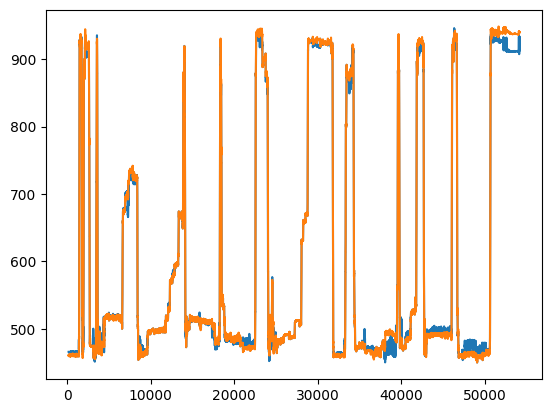

In [16]:
plt.plot(saline_dataframes[0]['center_x'])
plt.plot(saline_dataframes[0]['centerofMass']['x'])

## Behavior box center calculation

In [17]:
df_box = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

In [19]:
def calculate_center(row):
    box_center_x = (row['top_left_x'] + row['top_right_x'] + row['bottom_right_x'] + row['bottom_left_x']) / 4
    box_center_y = (row['top_left_y'] + row['top_right_y'] + row['bottom_right_y'] + row['bottom_left_y']) / 4
    return box_center_x, box_center_y

df_box['box_center_x'], df_box['box_center_y'] = zip(*df_box.apply(calculate_center, axis=1))


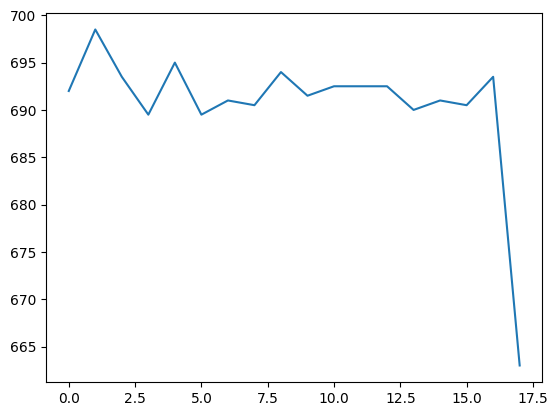

In [23]:
plt.plot(df_box['box_center_x'])

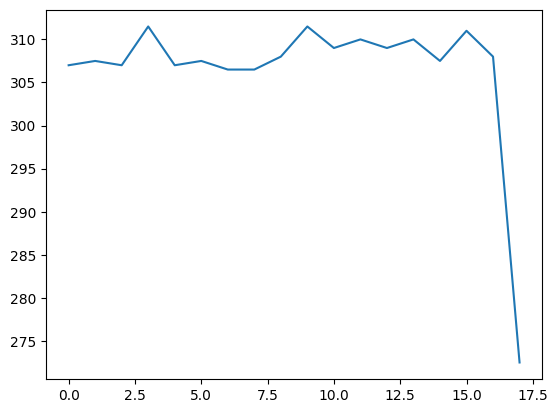

In [24]:
plt.plot(df_box['box_center_y'])

## Step 4: Calculate Euclidean Distance from Reference Point

In [34]:
def calculate_euclidean_distance(df):
    distance_df = pd.DataFrame()
    body_parts = [col for col in df.columns.get_level_values(0).unique() if col not in ['bodyparts', 'likelihood']]
    for body_part in body_parts:
        x = df[(body_part, 'x')]
        y = df[(body_part, 'y')]
        distance = np.sqrt(x**2 + y**2)
        distance_df[body_part] = distance
    return distance_df

saline_data_distance = [calculate_euclidean_distance(df) for df in saline_dataframes]
pfa_data_distance = [calculate_euclidean_distance(df) for df in pfa_dataframes]

In [45]:
saline_data_distance[1].shape

(56312, 12)

## Step 5: Apply PCA for Dimensionality Reduction (Optional, but can speed up t-SNE)

In [49]:
all_data_distance = pd.concat([pd.concat(saline_data_distance), pd.concat(pfa_data_distance)], axis=0)

# Ensure n_components is less than or equal to min(n_samples, n_features)
# n_components = min(50, all_data_distance.shape[0], all_data_distance.shape[1])
n_components = 2

pca = PCA(n_components=n_components)  
data_pca = pca.fit_transform(all_data_distance)


(511209, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

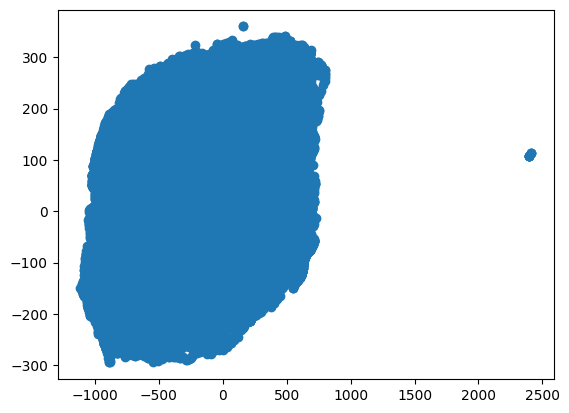

In [53]:
print(np.shape(data_pca))
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.show

## Step 6: Apply t-SNE for Visualization

In [54]:
tsne = TSNE(n_components=2, perplexity=200)
data_tsne = tsne.fit_transform(all_data_distance)

plt.figure(figsize=(10, 6))
plt.scatter(data_tsne[:len(pd.concat(saline_data_distance)), 0], 
            data_tsne[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_tsne[len(pd.concat(saline_data_distance)):, 0], 
            data_tsne[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.title('t-SNE Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

## Step 7: Apply UMAP for Visualization

In [29]:
reducer = umap.UMAP(random_state=42)
data_umap = reducer.fit_transform(data_pca)

plt.figure(figsize=(10, 6))
plt.scatter(data_umap[:len(pd.concat(saline_data_distance)), 0], 
            data_umap[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_umap[len(pd.concat(saline_data_distance)):, 0], 
            data_umap[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='upper right')
plt.title('UMAP Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()

C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 